1. Import Required Libraries

In [210]:
import os
import random

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR


# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models
from torchvision.transforms import ToTensor, Resize, Normalize
from torchvision.transforms import InterpolationMode


# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

# Check versions
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

2.5.1+cu124
0.20.1+cu124
1
NVIDIA GeForce RTX 3050 6GB Laptop GPU


2. Set the Hyperparameters

In [211]:
# Paths to real and fake image directories
train_real_path = r"D:\Projects\SP CUP Dataset\train\real" # r is because of the backslash causing \p 
train_fake_path = r"D:\Projects\SP CUP Dataset\train\fake" # to be interpreted as a special character

test_real_path = r"D:\Projects\SP CUP Dataset\valid\real"
test_fake_path = r"D:\Projects\SP CUP Dataset\valid\fake"

#Small Dataset
#train_real_path = r"D:\Projects\SP CUP Dataset\valid\real" # r is because of the backslash causing \p 
#train_fake_path = r"D:\Projects\SP CUP Dataset\valid\fake" # to be interpreted as a special character

#test_real_path = r"D:\Projects\SP CUP Dataset\Small train\real"
#test_fake_path = r"D:\Projects\SP CUP Dataset\Small train\fake"
#r"D:\Projects\SP CUP Dataset\Small train\real"
#r"D:\Projects\SP CUP Dataset\Small train\fake"
BATCH_SIZE = 16 # Batch size for training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


✔ 0 for real and 1 for fake since classes = ['real', 'fake']

✔ The train_dataloader is created with shuffle=True to shuffle the training data at the beginning of each epoch.

✔ The test_dataloader is created with shuffle=False to keep the order of the test data consistent.

✔Read efficientnet documentation and act accordingly

Way to save the model using checkpoints.

Way to get std and mean of the provided dataset

Apply regularization (Model markdown)

3. Set dataset folders for training

In [212]:
# Get the image filenames
train_real_count = len(os.listdir(train_real_path))
train_fake_count = len(os.listdir(train_fake_path))

test_real_count = len(os.listdir(test_real_path))
test_fake_count = len(os.listdir(test_fake_path))

print(f"Train Real images: {train_real_count}, Train Fake images: {train_fake_count}")
print(f"Test Real images: {test_real_count}, Test Fake images: {test_fake_count}")

Train Real images: 42690, Train Fake images: 219470
Test Real images: 1548, Test Fake images: 1524


4.1 Preparing Training Data

In [213]:
# Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

#Define the maximum number of samples per class
MAX_SAMPLES_PER_CLASS = 40000  # Programmer-defined limit

# Get the image filenames
train_real_images = os.listdir(train_real_path)
train_fake_images = os.listdir(train_fake_path)

# Apply the limit
train_real_images = train_real_images[:min(MAX_SAMPLES_PER_CLASS, len(train_real_images))]
train_fake_images = train_fake_images[:min(MAX_SAMPLES_PER_CLASS, len(train_fake_images))]

# Combine and label the dataset
train_balanced_dataset = [(os.path.join(train_real_path, img), 0) for img in train_real_images] + \
                   [(os.path.join(train_fake_path, img), 1) for img in train_fake_images]

# Shuffle the dataset
random.shuffle(train_balanced_dataset)

# Verify the limited dataset size
print(f"Total dataset size: {len(train_balanced_dataset)} (Real: {len(train_real_images)}, Fake: {len(train_fake_images)})")


Total dataset size: 80000 (Real: 40000, Fake: 40000)


4.2 Preparing Testing Data

In [214]:
# Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

#Define the maximum number of samples per class
MAX_SAMPLES_PER_CLASS = 40000  # Programmer-defined limit

# Get the image filenames
test_real_images = os.listdir(test_real_path)
test_fake_images = os.listdir(test_fake_path)

# Apply the limit
test_real_images = test_real_images[:min(MAX_SAMPLES_PER_CLASS, len(test_real_images))]
test_fake_images = test_fake_images[:min(MAX_SAMPLES_PER_CLASS, len(test_fake_images))]

# Combine and label the dataset
# test_balanced_dataset[0] = ('D:\\Projects\\SP CUP Dataset\\valid\\fake\\valid_fake_0228446.png', 1)
test_balanced_dataset = [(os.path.join(test_real_path, img), 0) for img in test_real_images] + \
                   [(os.path.join(test_fake_path, img), 1) for img in test_fake_images]

# Shuffle the dataset
random.shuffle(test_balanced_dataset)

# Verify the limited dataset size
print(f"Total dataset size: {len(test_balanced_dataset)} (Real: {len(test_real_images)}, Fake: {len(test_fake_images)})")


Total dataset size: 3072 (Real: 1548, Fake: 1524)


5. Visualize the dataset

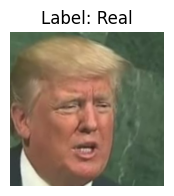

Image file name: valid_real_0519374.png
Image Shape: (256, 256)


In [215]:
# Load the first image from the balanced dataset
image_path, label = train_balanced_dataset[0]
image_path, label = test_balanced_dataset[0]

# Open the image using PIL
image = Image.open(image_path)

# Display the image using matplotlib
plt.figure(figsize=(2, 2))  # Adjust the figsize to make the image smaller
plt.imshow(image)
plt.title(f"Label: {'Real' if label == 0 else 'Fake'}")
plt.xlabel(os.path.basename(image_path))  # Display the image name
plt.axis('off')  # Hide the axis
plt.show()

# Display the image file name after the image
print(f"Image file name: {os.path.basename(image_path)}")
print(f"Image Shape: {image.size}")

5.1 Plot more Images

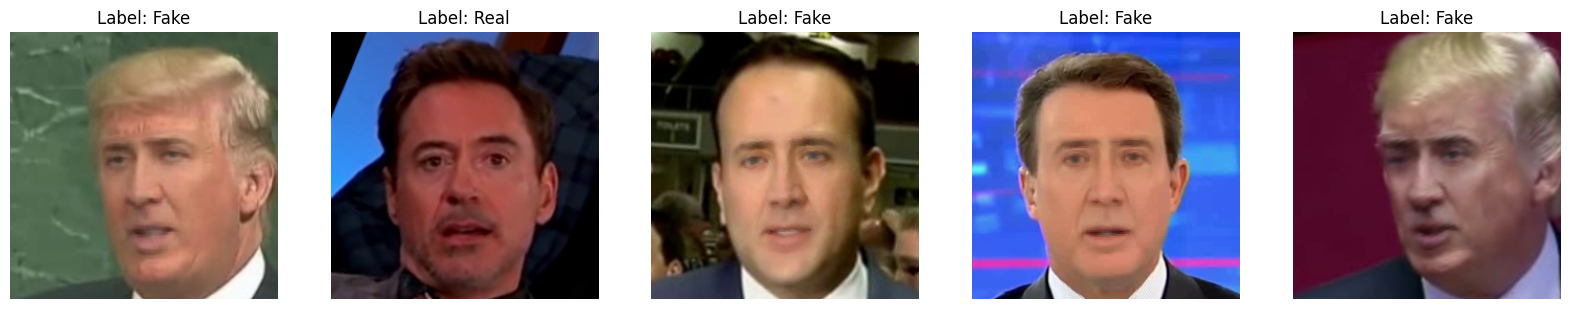

Image file name: valid_fake_0122013.png
Image file name: valid_real_0637434.png
Image file name: valid_fake_0938411.png
Image file name: valid_fake_0299716.png
Image file name: valid_fake_0912511.png


In [216]:
# Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Randomly select 5 images from the balanced dataset
#selected_indices = random.sample(range(len(train_balanced_dataset)), 5)
#balanced_dataset5_1 = train_balanced_dataset
selected_indices = random.sample(range(len(test_balanced_dataset)), 5)
balanced_dataset5_1 = test_balanced_dataset


# Display 5 images in a row
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i, idx in enumerate(selected_indices):
    image_path, label = balanced_dataset5_1[idx]
    image = Image.open(image_path)
    
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {'Real' if label == 0 else 'Fake'}")
    axes[i].set_xlabel(os.path.basename(image_path))  # Display the image name
    axes[i].axis('off')  # Hide the axis

plt.show()

# Display the image file names after the images
for idx in selected_indices:
    image_path, _ = balanced_dataset5_1[idx]
    print(f"Image file name: {os.path.basename(image_path)}")
    

6. Getting the datasets ( Setup training data)

In [217]:
# Define the dataset class
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        super().__init__()  # Call the parent class's init method
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        #return image, label, img_path
        return image, label
    

transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),  # First resize to 256
    transforms.CenterCrop(224),  # Then center crop to 224
    transforms.ToTensor(),  # Converts to tensor and scales to [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

#Define the classes
classes = ['real', 'fake']

#Create the dataset
train_data = ImageDataset(train_balanced_dataset, 
                          transform=transform)

#Create the dataset
test_data = ImageDataset(test_balanced_dataset, 
                        transform=transform)

# Example: Print the class name of a label
for image, label in test_data:
    class_name = classes[label]
    print(f"Image Shape {image.shape}, Image label: {label}, Class name: {class_name}")
    break  # Just print the first one for demonstration

Image Shape torch.Size([3, 224, 224]), Image label: 0, Class name: real


7. Visualize train_data and labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.50910366..1.6108497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5075778..1.6073294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6244541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


Image Name: D:\Projects\SP CUP Dataset\train\fake\train_fake_0071346.png
Image Name: D:\Projects\SP CUP Dataset\train\fake\train_fake_0156124.png
Image Name: D:\Projects\SP CUP Dataset\train\real\train_real_0388950.png
Image Name: D:\Projects\SP CUP Dataset\train\real\train_real_0764435.png
Image Name: D:\Projects\SP CUP Dataset\train\real\train_real_0887929.png


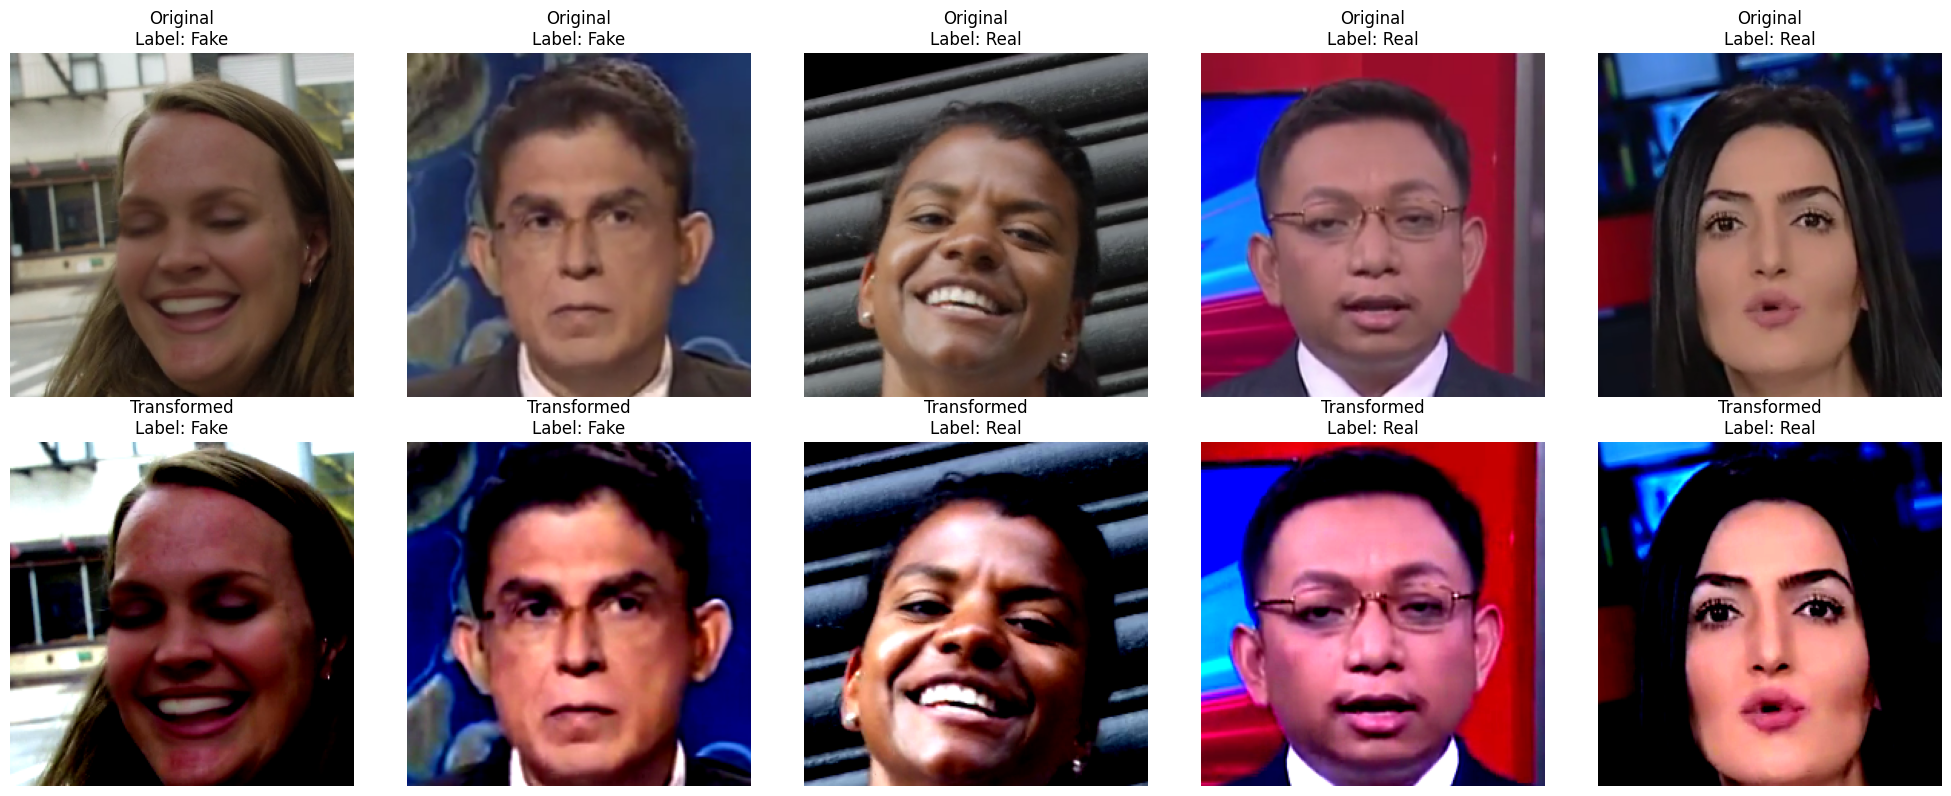

In [218]:
# Set the random seed for reproducibility
torch.manual_seed(42)
torch.random.manual_seed(42)

# Randomly select 5 images from the balanced dataset
selected_indices = random.sample(range(len(train_balanced_dataset)), 5)

# Display 5 images before and after transform
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns

for i, idx in enumerate(selected_indices):
    image_path, label = train_balanced_dataset[idx]
    image = Image.open(image_path).convert("RGB")
    
    # Display original image
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Original\nLabel: {'Real' if label == 0 else 'Fake'}")
    axes[0, i].axis('off')  # Hide the axis

    # Apply transform and display transformed image
    transformed_image = transform(image)
    axes[1, i].imshow(transformed_image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize the image
    axes[1, i].set_title(f"Transformed\nLabel: {'Real' if label == 0 else 'Fake'}")
    axes[1, i].axis('off')  # Hide the axis

    print(f"Image Name: {image_path}")

plt.tight_layout()
plt.show()

In [219]:
print(len(train_data)) 
print(len(test_data))

#image, label = train_data[700] # Label is 1
image, label = train_data[1600] # Label is 0
print(image.shape, label)

# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {[label]}")

80000
3072
torch.Size([3, 224, 224]) 0
Image shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image label: [0]


7.1 Checking Labels of more data

In [220]:
# Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#dataset = train_data
dataset = test_data


# Select 50 random images
selected_indices = random.sample(range(len(dataset)), 10)

# Print the shape of images and labels of 50 random images
for idx in selected_indices:
    image, label = dataset[idx]
    image_path, _ = dataset.data[idx]
    print(f"Image file name: {os.path.basename(image_path)}")
    print(f"Image shape: {image.shape}, Label: {label}")

Image file name: valid_fake_0167113.png
Image shape: torch.Size([3, 224, 224]), Label: 1
Image file name: valid_fake_0337839.png
Image shape: torch.Size([3, 224, 224]), Label: 1
Image file name: valid_fake_0268756.png
Image shape: torch.Size([3, 224, 224]), Label: 1
Image file name: valid_fake_0050268.png
Image shape: torch.Size([3, 224, 224]), Label: 1
Image file name: valid_fake_0852912.png
Image shape: torch.Size([3, 224, 224]), Label: 1
Image file name: valid_real_0395285.png
Image shape: torch.Size([3, 224, 224]), Label: 0
Image file name: valid_fake_0530143.png
Image shape: torch.Size([3, 224, 224]), Label: 1
Image file name: valid_real_0768412.png
Image shape: torch.Size([3, 224, 224]), Label: 0
Image file name: valid_fake_0369189.png
Image shape: torch.Size([3, 224, 224]), Label: 1
Image file name: valid_real_0116879.png
Image shape: torch.Size([3, 224, 224]), Label: 0


7.2 Visualize our data

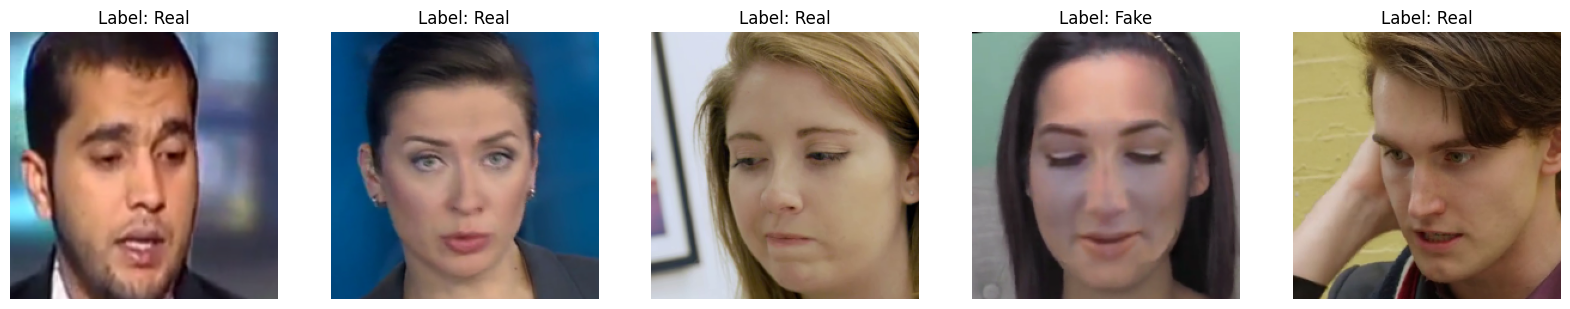

Image file name: train_real_0863222.png
Image file name: train_real_0306334.png
Image file name: train_real_0336883.png
Image file name: train_fake_0061062.png
Image file name: train_real_0912635.png


In [221]:
# Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Randomly select 5 images from the train_data dataset
selected_indices = random.sample(range(len(train_data)), 5)

# Display 5 images in a row
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i, idx in enumerate(selected_indices):
    image, label = train_data[idx]
    image = image.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize the image
    
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {'Real' if label == 0 else 'Fake'}")
    axes[i].axis('off')  # Hide the axis

plt.show()

# Display the image file names after the images
for idx in selected_indices:
    image_path, _ = train_data.data[idx]
    print(f"Image file name: {os.path.basename(image_path)}")

#These images are from the dataset after appplying the transformation ao the image is cropped

7.3 Visualize more data

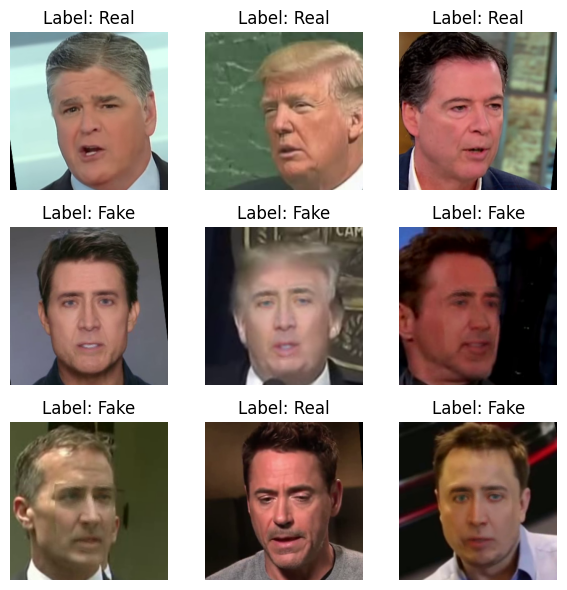

Image file name: valid_real_0455716.png
Image file name: valid_real_0584748.png
Image file name: valid_real_0648789.png
Image file name: valid_fake_0769810.png
Image file name: valid_fake_0133335.png
Image file name: valid_fake_0638272.png
Image file name: valid_fake_0401819.png
Image file name: valid_real_0768681.png
Image file name: valid_fake_0927727.png


In [222]:
# Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#balanced_dataset7_3 = train_balanced_dataset
balanced_dataset7_3 = test_balanced_dataset

# Randomly select 9 images from the balanced dataset
selected_indices = random.sample(range(len(balanced_dataset7_3)), 9)

# Display 9 images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(6, 6))  # 3 rows, 3 columns

for i, idx in enumerate(selected_indices):
    image_path, label = balanced_dataset7_3[idx]
    image = Image.open(image_path)
    
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(f"Label: {'Real' if label == 0 else 'Fake'}")
    ax.set_xlabel(os.path.basename(image_path))  # Display the image name
    ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

# Display the image file names after the images
for idx in selected_indices:
    image_path, _ = balanced_dataset7_3[idx]
    print(f"Image file name: {os.path.basename(image_path)}")

In [223]:
train_data

8. Prepare DataLoader

In [224]:
# Create the DataLoader
train_dataloader = DataLoader(train_data, 
                        batch_size=BATCH_SIZE,
                        shuffle=False)

test_dataloader = DataLoader(test_data, 
                        batch_size=BATCH_SIZE,
                        shuffle=False)

# Example: Iterate through the DataLoader
for images, labels in test_dataloader:
    print(images.shape, labels.shape)
    break

print(images[0].shape)
train_dataloader, test_dataloader

torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([3, 224, 224])


(<torch.utils.data.dataloader.DataLoader at 0x1e0bf7bad50>,
 <torch.utils.data.dataloader.DataLoader at 0x1e0bff1e810>)

8.1 Check what we have created

In [225]:
# Let's check out what what we've created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}... = {BATCH_SIZE*len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}... = {BATCH_SIZE*len(test_dataloader)}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001E0BF7BAD50>, <torch.utils.data.dataloader.DataLoader object at 0x000001E0BFF1E810>)
Length of train_dataloader: 5000 batches of 16... = 80000
Length of test_dataloader: 192 batches of 16... = 3072


8.2 What's inside the dataloaders

In [226]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

9. Building a baseline Model

In [227]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 50176]) -> [color_channels, height*width]


9.1 Modelv0

In [20]:
#from torch import nn
#class DeepFakeDetectV0(nn.Module):
#  def __init__(self,
#               input_shape: int,
#               hidden_units: int,
#               output_shape: int):
#    super().__init__()
#    self.layer_stack = nn.Sequential(
#        nn.Flatten(),
#        nn.Linear(in_features=input_shape,
#                  out_features=hidden_units),
#        nn.Linear(in_features=hidden_units,
#                  out_features=output_shape)
#    )
#
#  def forward(self, x):
#    return self.layer_stack(x)

In [21]:
#Try to use efficientnet_b3 or efficientnet_b7

# Load pre-trained EfficientNet model
class DeepFakeDetectV0(nn.Module):
    def __init__(self, output_shape: int):
        super(DeepFakeDetectV0, self).__init__()
        # Load pre-trained EfficientNet model
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        
        # Unfreeze more layers
        for param in self.efficientnet.parameters():
            param.requires_grad = True
        
        # Replace the final fully connected layer
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_ftrs, output_shape)
        )
        
    def forward(self, x):
        return self.efficientnet(x)

Regularization is a technique used in machine learning and deep learning to prevent overfitting, which occurs when a model learns the training data too well, including its noise and outliers, and performs poorly on new, unseen data. Regularization techniques add constraints or penalties to the model to encourage it to generalize better to new data.

Here are some common regularization techniques:

L1 and L2 Regularization:

L1 Regularization (Lasso): Adds the absolute value of the coefficients as a penalty term to the loss function. It can lead to sparse models where some feature weights are exactly zero, effectively performing feature selection.
L2 Regularization (Ridge): Adds the squared value of the coefficients as a penalty term to the loss function. It helps in reducing the magnitude of the coefficients but does not lead to sparsity.
Example in PyTorch:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

Dropout:

Dropout is a technique where randomly selected neurons are ignored during training. This prevents the model from becoming too reliant on specific neurons and encourages it to learn more robust features.
Example in PyTorch:

self.efficientnet.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),  # Dropout with a probability of 0.5
    nn.Linear(num_ftrs, output_shape)
)

Data Augmentation:

Data augmentation involves creating new training samples by applying random transformations (e.g., rotations, flips, crops) to the existing data. This increases the diversity of the training data and helps the model generalize better.
Example in PyTorch:

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Early Stopping:

Early stopping involves monitoring the model's performance on a validation set and stopping the training process when the performance stops improving. This prevents the model from overfitting the training data.
Example:

best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    # Training code...
    val_loss = evaluate(model, val_dataloader)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

Batch Normalization:

Batch normalization normalizes the inputs of each layer to have a mean of zero and a standard deviation of one. This helps in stabilizing and accelerating the training process.
Example in PyTorch:

self.efficientnet.features.add_module("batch_norm", nn.BatchNorm2d(num_features))

By incorporating these regularization techniques, you can improve the generalization ability of your model and reduce the risk of overfitting.

In [22]:
len(classes)

2

9.2 Setup the model for the first time

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


torch.manual_seed(42)
model_0 = DeepFakeDetectV0(output_shape=1)
model_0.to(device)

# Check the device of the model
model_0_device = next(model_0.parameters()).device
print(f"Model is on device: {model_0_device}")
model_0

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model is on device: cuda:0


DeepFakeDetectV0(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
            

In [24]:
# Setup model with input parameters
#model_0 = DeepFakeDetectV0(
#    input_shape=3*224*224, # this is 128*128 (height*width)
#    hidden_units=10, # how mnay units in the hidden layer
#    output_shape=1 # one for every class
#).to("cpu")

9.3 Send a random value through to check the output

In [25]:
# Test with random tensor (batch_size=32, channels=3, height=224, width=224)
test_input = torch.randn(32, 3, 224, 224).to(device)
output = model_0(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Sample predictions:\n{output[:5].cpu().detach().numpy()}")

Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 1])
Sample predictions:
[[-0.0065593 ]
 [-0.00191861]
 [-0.3246561 ]
 [-0.20881483]
 [-0.05703238]]


In [26]:
dummy_x = torch.rand([1, 3, 224, 224]).to(device)
model_0(dummy_x)


tensor([[-0.0314]], device='cuda:0', grad_fn=<AddmmBackward0>)

9.4 Check the State Dictionary of the model

In [27]:
model_0.state_dict()

OrderedDict([('efficientnet.features.0.0.weight',
              tensor([[[[ 1.2156e-01,  6.5634e-01,  4.5671e-01],
                        [-1.1092e-01, -6.1004e-01, -3.3345e-01],
                        [ 2.7964e-02, -1.0312e-01, -1.0324e-01]],
              
                       [[ 6.3553e-02,  1.6552e+00,  1.7436e+00],
                        [-1.3646e-01, -1.5367e+00, -1.5937e+00],
                        [ 5.0196e-02, -1.1360e-01, -1.2600e-01]],
              
                       [[ 8.7276e-02,  3.6126e-01,  2.6946e-01],
                        [-1.1966e-01, -2.8122e-01, -2.1883e-01],
                        [ 3.6658e-02, -7.0751e-02, -8.1917e-02]]],
              
              
                      [[[ 1.6449e-01, -2.0041e-01,  8.3092e-02],
                        [ 8.9009e-01, -1.2110e+00,  2.7610e-01],
                        [ 1.0740e+00, -1.2603e+00,  2.0645e-01]],
              
                       [[ 3.2816e-01, -4.3449e-01,  1.8769e-01],
                        [

10. Setup Loss, Optimizer and evaluation metrics

10.1 Setup Loss and Optimizer

In [28]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(params=model_0.parameters(),
                            #lr=0.01)
# Define the optimizer
optimizer = optim.Adam(model_0.parameters(), lr=0.01)

# Define the learning rate scheduler
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

10.2 Function to time our experiments

In [29]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


1.2599994079209864e-05

In [30]:
# Iterate through the test_dataloader and print the first 5 values
for i, (images, labels) in enumerate(test_dataloader):
    if i < 1:
        print(f"Batch {i+1}:")
        print(f"Images: {images}")
        print(f"Labels: {labels}")
    else:
        break

Batch 1:
Images: tensor([[[[-1.1075, -1.0562, -1.0390,  ..., -2.1179, -2.1179, -2.1179],
          [-1.1247, -1.0733, -1.0219,  ..., -2.1179, -2.1179, -2.1179],
          [-1.1418, -1.0904, -1.0219,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-0.8335, -0.9020, -0.9705,  ..., -2.1179, -2.1179, -2.1179],
          [-0.7993, -0.8164, -0.8335,  ..., -2.1179, -2.1179, -2.1179],
          [-0.7993, -0.7137, -0.6794,  ..., -2.1179, -2.1179, -2.1179]],

         [[-0.9853, -0.9328, -0.9153,  ..., -2.0357, -2.0357, -2.0357],
          [-1.0028, -0.9503, -0.8978,  ..., -2.0357, -2.0357, -2.0357],
          [-1.0203, -0.9678, -0.8978,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-0.7402, -0.8102, -0.8803,  ..., -2.0357, -2.0357, -2.0357],
          [-0.7052, -0.7227, -0.7402,  ..., -2.0357, -2.0357, -2.0357],
          [-0.7052, -0.6176, -0.5826,  ..., -2.0357, -2.0357, -2.0357]],

         [[-0.6715, -0.6193, -0.6018,  ..., -1.8044, -1.8044, -1.8044],
          [-0

In [31]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  for X_test, y_test in test_dataloader:
    X_test, y_test = X_test.to(device), y_test.to(device)  # Move tensors to the same device as the model
    # 1. Forward pass
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0435],
        [ 0.2337],
        [-0.4102],
        [-0.2955],
        [ 0.2355]], device='cuda:0')

In [32]:
y_test[:5]

tensor([0, 1, 1, 0, 1], device='cuda:0')

In [33]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4891],
        [0.5582],
        [0.3989],
        [0.4267],
        [0.5586]], device='cuda:0')

In [34]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# Convert the tensor to a list of labels
y_pred_labels = [classes[int(label)] for label in y_preds]

print(y_pred_labels)

['real', 'fake', 'real', 'real', 'fake']


In [35]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

11. Creating a Training loop and training the model

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 10

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  ### Training
  train_loss, train_acc = 0, 0
  batch_accuracy = 0

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(tqdm(train_dataloader)):
    # Put data to target device
    X, y = X.to(device), y.float().to(device)

    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X).squeeze()
    #print(y_pred.type)
    #print(y_pred[0])

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred.view(-1), y.float())
    train_loss += loss.item() # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()

    # Calculate accuracy
    y_pred_class = torch.round(torch.sigmoid(y_pred))
    #print(y_pred_class)
    #print(y_pred_class.view(-1))
    batch_accuracy = (y_pred_class.view(-1) == y).sum().item() / len(y_pred_class)
    #print(f"Batch accuracy: {batch_accuracy}")

    # Accumulate the batch accuracy to the training accuracy
    train_acc += batch_accuracy
    #print(f"Cumulative training accuracy: {train_acc}")

    # Print out what's happening
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f"\nTrain loss: {train_loss:.4f}")
  print(f"Cumulative training accuracy: {train_acc}")

  ### Testing
  test_loss, correct_predictions, total_predictions = 0, 0, 0
  real_as_real, real_as_fake, fake_as_real, fake_as_fake = 0, 0, 0, 0
  model_0.eval()
  with torch.inference_mode():
      for i, (X_test, y_test) in enumerate(test_dataloader):
          # Put data to target device
          X_test, y_test = X_test.to(device), y_test.float().to(device)

          # 1. Forward pass
          test_pred = model_0(X_test).squeeze()

          # 2. Calculate loss (accumulatively)
          test_loss += loss_fn(test_pred, y_test.float()).item()

          # 3. Calculate accuracy
          test_pred_class = torch.round(torch.sigmoid(test_pred))
          correct_predictions += (test_pred_class.view(-1) == y_test).sum().item()
          total_predictions += len(y_test)

          # Print image names and predictions
          for j in range(len(X_test)):
              image_index = i * test_dataloader.batch_size + j
              image_name = test_dataloader.dataset.data[image_index][0]
              true_label = test_dataloader.dataset.data[image_index][1]
              predicted_label = test_pred_class[j].item()
              #print(f"Image: {image_name}, True Label: {true_label}, Predicted Label: {predicted_label}")
              #print(f"Image: {image_name}, True Label: {classes[int(true_label)]}, Predicted Label: {classes[int(predicted_label)]}")

              if true_label == 0 and predicted_label == 0:
                  real_as_real += 1
              elif true_label == 0 and predicted_label == 1:
                  real_as_fake += 1
              elif true_label == 1 and predicted_label == 0:
                  fake_as_real += 1
              elif true_label == 1 and predicted_label == 1:
                  fake_as_fake += 1
              #print(real_as_real, real_as_fake, fake_as_real, fake_as_fake)

      # Calculate the test loss average per batch
      test_loss /= len(test_dataloader)

      # Calculate the test accuracy
      #test_acc = correct_predictions / total_predictions
      test_acc = (real_as_real + fake_as_fake) / (real_as_real + real_as_fake + fake_as_real + fake_as_fake)
      print(f"Real images identified as real: {real_as_real}")
      print(f"Real images identified as fake: {real_as_fake}")
      print(f"Fake images identified as real: {fake_as_real}")
      print(f"Fake images identified as fake: {fake_as_fake}")
      print(f"\nReal images Total: {real_as_real + real_as_fake} | Fake images Total: {fake_as_real + fake_as_fake}")
      print(f"\nTest loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Print out what's happening
print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")


# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------


  0%|          | 0/5000 [00:00<?, ?it/s]

Looked at 0/80000 samples.
